In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [9]:
cd ../analysis/

/srv/data/home/jlee782/segmentation/analysis


In [2]:
import pickle as pkl
from PixelEM import * 

In [175]:
sample = "10workers_rand0"
objid = 10
tiles = pkl.load(open("../analysis/pixel_em/{}/obj{}/tiles.pkl".format(sample,objid)))
log_probability_in_mask=pkl.load(open("../analysis/pixel_em/{}/obj{}/basic_p_in_mask_ground_truth.pkl".format(sample,objid)))
log_probability_not_in_mask =pkl.load(open("../analysis/pixel_em/{}/obj{}/basic_p_not_in_ground_truth.pkl".format(sample,objid)))

In [176]:
# if tile already in ground truth, then we don't care, because we are only trying to figure out which tiles outside of the ground truth we should add. 
candidate_tiles_lst = []
metric_lst = []
ia_lst = [] 
# compute I/O metric for all tiles
for tile in tiles:
    #intersection_area = float(len(gt_idxs.intersection(set(tile))))
    pInT = np.abs(log_probability_in_mask[list(tile)[0]]) # all pixels in same tile should have the same pInT
    pNotInT = np.abs(log_probability_not_in_mask[list(tile)[0]])
    norm_pInT = pInT/(pNotInT+pInT) #normalized pInT 
    intersection_area = len(tile) * norm_pInT #estimation
    outside_area = float(len(tile) - intersection_area)
    if outside_area!=0: #otherwise, tile encapsulated by GT, no need to determine whether to pick or not.
        metric = intersection_area/outside_area
        metric_lst.append(metric)
        candidate_tiles_lst.append(tile)
        ia_lst.append(intersection_area)

In [185]:
srt_decr_idx = np.argsort(metric_lst)[::-1] # sorting from largest to smallest metric_lst
GT_area = 0 #new ground truth area
ia_cum = 0 #cumulative intersection area
jaccard_lst = []
picked_tiles = []
prev_jac = -1000
for tidx  in srt_decr_idx:
    tile = candidate_tiles_lst[tidx]
    ia = ia_lst[tidx]
    jaccard = ia_cum/float(GT_area+len(tile))
    ia_cum +=ia
    GT_area += len(tile)
    jaccard_lst.append(jaccard)
    if jaccard > prev_jac: 
        picked_tiles.append(tile)
        prev_jac=jaccard
    else: # stop when jaccard starts decreasing after the addition of a tile
        #break
        continue #for debugging purposes to see how jaccard_lst evolves, technically should break here

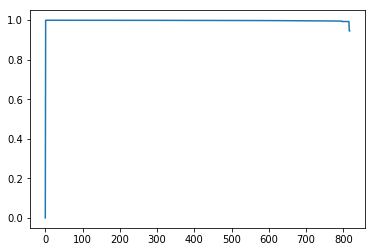

In [186]:
plt.plot(jaccard_lst)

In [188]:
len(picked_tiles)

2

In [190]:
img = np.zeros_like(log_probability_in_mask)
for t in picked_tiles:
    for tidx in t:
        img[tidx]=1

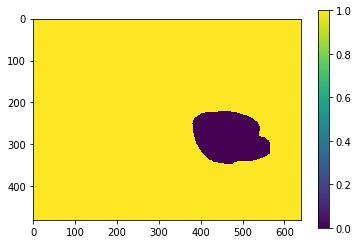

In [192]:
plt.imshow(img)
plt.colorbar()